In [1]:
import sys; sys.path += ['..', '../src']

Downloading the data and external libs

In [2]:
%%bash

# Downloading external libs
git clone https://github.com/facebookresearch/MUSE ../ext-libs/MUSE
git clone https://github.com/moses-smt/mosesdecoder ../ext-libs/mosesdecoder

# News (monolingual) corpus for training
mkdir -p ../data/news
wget -q -O ../data/news/news.2016.en.shuffled.gz "http://data.statmt.org/wmt17/translation-task/news.2016.en.shuffled.gz"
wget -q -O ../data/news/news.2016.fr.shuffled.gz "http://data.statmt.org/wmt17/translation-task/news.2016.fr.shuffled.gz"
wget -q -O ../data/europarl/fr-en.tgz "http://www.statmt.org/europarl/v7/fr-en.tgz"

# Europarl (parallel) corpus for testing and validation
mkdir -p ../data/europarl
gunzip -f ../data/news/news.2016.en.shuffled.gz
gunzip -f ../data/news/news.2016.fr.shuffled.gz
gunzip -f ../data/europarl/fr-en.tgz
tar xf ../data/europarl/fr-en.tar -C ../data/europarl

# Pretrained word embeddings
mkdir -p ../trained_models
wget -q -O ../trained_models/wiki.en.vec https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
wget -q -O ../trained_models/wiki.fr.vec https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec
    
# To train cross-aligned embeddings we have to download dictionary for testing
wget -q -O ../ext-libs/MUSE/data/crosslingual/dictionaries/en-fr.5000-6500.txt https://s3.amazonaws.com/arrival/dictionaries/en-fr.5000-6500.txt

fatal: destination path '../ext-libs/MUSE' already exists and is not an empty directory.
fatal: destination path '../ext-libs/mosesdecoder' already exists and is not an empty directory.


Tokenizing the data

In [3]:
%%bash

mosesdecoder="../ext-libs/mosesdecoder"
generated_data_dir="../data/generated"

mkdir -p $generated_data_dir

threads=10

cat "../data/news/news.2016.en.shuffled" | \
    $mosesdecoder/scripts/tokenizer/normalize-punctuation.perl | \
    $mosesdecoder/scripts/tokenizer/tokenizer.perl -threads $threads > \
    $generated_data_dir/news.en.tok
cat "../data/news/news.2016.fr.shuffled" | \
    $mosesdecoder/scripts/tokenizer/normalize-punctuation.perl | \
    $mosesdecoder/scripts/tokenizer/tokenizer.perl -threads $threads > \
    $generated_data_dir/news.fr.tok
cat "../data/europarl/europarl-v7.fr-en.en" | \
    $mosesdecoder/scripts/tokenizer/normalize-punctuation.perl | \
    $mosesdecoder/scripts/tokenizer/tokenizer.perl -threads $threads > \
    $generated_data_dir/europarl.en.tok
cat "../data/europarl/europarl-v7.fr-en.fr" | \
    $mosesdecoder/scripts/tokenizer/normalize-punctuation.perl | \
    $mosesdecoder/scripts/tokenizer/tokenizer.perl -threads $threads > \
    $generated_data_dir/europarl.fr.tok

Tokenizer Version 1.1
Language: en
Number of threads: 10
cat: ../data/news/news.2016.fr.shuffled: No such file or directory
Tokenizer Version 1.1
Language: en
Number of threads: 10
Tokenizer Version 1.1
Language: en
Number of threads: 10
Tokenizer Version 1.1
Language: en
Number of threads: 10


Learning unsupervised cross alignments. It can take several hours

In [14]:
!mkdir -p ../unsupervised_embs

# We have to be to MUSE dir to run this because of
# https://github.com/facebookresearch/MUSE/issues/3
!cd ../ext-libs/MUSE && python unsupervised.py --src_lang en --tgt_lang fr \
    --src_emb ../../trained_models/wiki.en.vec --tgt_emb ../../trained_models/wiki.fr.vec \
    --exp_path ../../unsupervised_embs --verbose=0

Impossible to import Faiss library!! Switching to standard nearest neighbors search implementation, this will be significantly slower.



In [20]:
!mv ../unsupervised_embs/vectors-en.txt ../trained_models/unsupervised.wiki.multi.en.vec
!mv ../unsupervised_embs/vectors-fr.txt ../trained_models/unsupervised.wiki.multi.fr.vec
# !rm -rf ../unsupervised_embs

Loading the data for training

In [1]:
import sys; sys.path += ['..', '../src']

In [2]:
import os

DATA_PATH = '../data/generated'

train_src_path = os.path.join(DATA_PATH, 'news.en.tok')
train_trg_path = os.path.join(DATA_PATH, 'news.fr.tok')
val_src_path = os.path.join(DATA_PATH, 'europarl.en.tok')
val_trg_path = os.path.join(DATA_PATH, 'europarl.fr.tok')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

Building vocabularies (just take 50k most frequent words + special tokens)

In [3]:
from collections import Counter
from src.vocab import Vocab

vocab_size = 50000

src_word_freqs = Counter(w for s in train_src for w in s.split())
trg_word_freqs = Counter(w for s in train_trg for w in s.split())

src_tokens = list(Vocab._default_tokens) + [w for w,_ in src_word_freqs.most_common(vocab_size)]
trg_tokens = list(Vocab._default_tokens) + [w for w,_ in trg_word_freqs.most_common(vocab_size)]

vocab_src = Vocab(src_tokens)
vocab_trg = Vocab(trg_tokens)

In [4]:
# Processing long sentences will cause OOM errors on my GPU
# So let's cut them out.
max_len = 50

# Simple preprocessing: crop lines and remove empty sentences
train_src = [s.split()[:max_len-2] for s in train_src if len(s) != 0]
train_trg = [s.split()[:max_len-2] for s in train_trg if len(s) != 0]
val_src = [s.split()[:max_len-2] for s in val_src if len(s) != 0]
val_trg = [s.split()[:max_len-2] for s in val_trg if len(s) != 0]

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [5]:
import os
import torch

from src.models import Transformer
from src.utils.data_utils import load_embeddings, init_emb_matrix
from src.models import SimpleTransformerClassifier

transformer_kwargs = {'d_model': 300, 'd_word_vec': 300}
transformer = Transformer(len(vocab_src), len(vocab_trg), max_len, **transformer_kwargs)
discriminator = SimpleTransformerClassifier(2, max_len, **transformer_kwargs)

# Initializing transformer encoder and decoder with embeddings
# embeddings_src = load_embeddings('../trained_models/unsupervised.wiki.multi.en.vec')
# embeddings_trg = load_embeddings('../trained_models/unsupervised.wiki.multi.fr.vec')

# init_emb_matrix(transformer.encoder.src_word_emb.weight.data, embeddings_src, vocab_src.token2id)
# init_emb_matrix(transformer.decoder.tgt_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)
transformer.load_state_dict(torch.load('../trained_models/umt_transformer.pth'))
discriminator.load_state_dict(torch.load('../trained_models/umt_discriminator.pth'))

In [6]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam

%matplotlib inline

from src.trainers import UMTTrainer
from src.dataloaders import UMTBatcher
from src.dataloaders import Batcher
from src.vocab import constants

use_cuda = torch.cuda.is_available()

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

reconstruct_src_criterion = reconstruction_criterion(len(vocab_src))
reconstruct_trg_criterion = reconstruction_criterion(len(vocab_trg))
adv_criterion = nn.BCEWithLogitsLoss()

transformer_optimizer = Adam([
    {'params': transformer.get_trainable_params_without_embs(), 'lr': 1e-4},
    {'params': transformer.get_embs_parameters(), 'lr': 5e-6}
])
# transformer_optimizer = Adam(trainable_params_without_enc_embs(transformer), lr=1e-4)
discriminator_optimizer = Adam(discriminator.trainable_parameters(), lr=1e-4)

training_data = UMTBatcher(train_src_idx, train_trg_idx, vocab_src,
                           vocab_trg, batch_size=16, shuffle=True)
val_data = Batcher(val_src_idx[:64], val_trg_idx[:64], vocab_src.token2id,
                   vocab_trg.token2id, batch_size=16, shuffle=False)

training_config = {
    'max_num_epochs': 10,
    'start_bt_from_iter': 100000,
    'gen_loss_coef': 0.1
}

trainer = UMTTrainer(transformer, discriminator, vocab_src, vocab_trg,
                  transformer_optimizer, discriminator_optimizer,
                  reconstruct_src_criterion, reconstruct_trg_criterion, adv_criterion,
                  training_config)

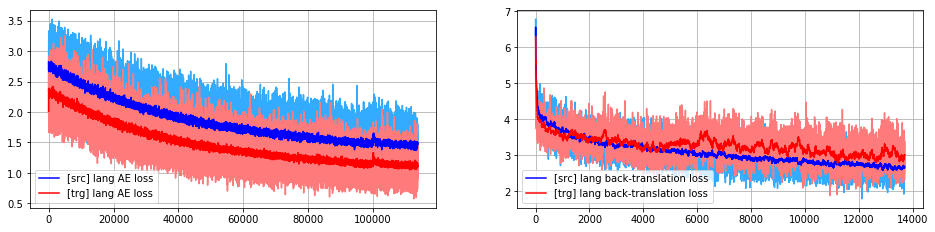

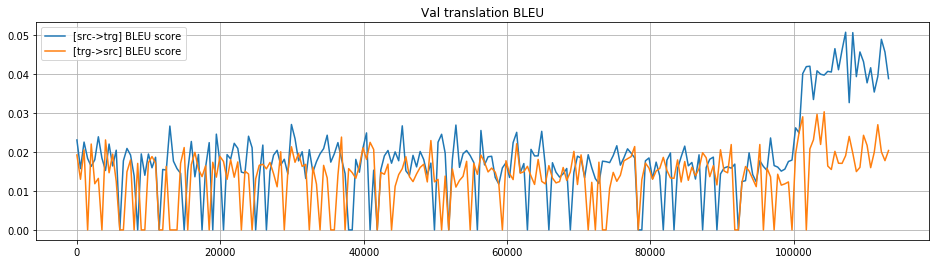

 20%|██        | 97549/478882 [18:19:09<71:36:47,  1.48it/s]

In [ ]:
trainer.run_training(training_data, val_data, plot_every=50, val_bleu_every=500)

In [10]:
torch.save(transformer.cuda().state_dict(), '../trained_models/umt_transformer.pth')
torch.save(discriminator.cuda().state_dict(), '../trained_models/umt_discriminator.pth')

Let's compute final validation scores on larger datasets

In [6]:
val_data = Batcher(val_src_idx[64:1000], val_trg_idx[64:1000], vocab_src.token2id,
                   vocab_trg.token2id, batch_size=16, shuffle=False)

scores, translations = trainer.validate_bleu(val_data, return_results=True)

In [7]:
scores

(0.2927952142628255, 0.3078507042173565)

In [8]:
for i in range(5):
    print('Source:             ', translations['targets_trg_to_src'][i])
    print('Translation:        ', translations['translations_src_to_trg'][i])
    print('Target:             ', translations['targets_src_to_trg'][i])
    print('Target translation: ', translations['translations_trg_to_src'][i])
    print()

Source:              A group of men are loading cotton onto a truck
Translation:         Un groupe d'enfants font du rafting derrière un camion
Target:              Un groupe d'hommes chargent du coton dans un camion
Target translation:  Man in an office of a truck

Source:              A man sleeping in a green room on a couch .
Translation:         Un homme dormant dans une pièce verte sur un lit .
Target:              Un homme dormant dans une chambre verte sur un canapé .
Target translation:  A man sleeping in a green room on a couch .

Source:              A boy wearing headphones sits on a woman's shoulders .
Translation:         Un garçon portant des écouteurs se tient sur les genoux d'une femme .
Target:              Un garçon avec un casque est assis sur les épaules d'une femme .
Target translation:  A boy with a helmet is sitting on top of a woman's shoulders .

Source:              Two men setting up a blue ice fishing hut on an iced over lake
Translation:         Deux homme